In [1]:
import numpy as np
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex, plot_state_city
from qiskit.extensions import Initialize
from qiskit.result import marginal_counts

## Creating New Quantum State to Teleport

We create a quantum circuit consisting of 3 qubits and 3 bits. We then rotate qubit 0 by a chosen angle, in this case $\frac{\pi}{3}$, to create the new state to teleport. We'll call this state $\alpha|0\rangle+\beta|1\rangle$.

Next we run a statevector simulation. A statevector simulation involves simulating a quantum circuit without any measurements, meaning we obtain the new quantum statevector at the end of the circuit.

Statevector([0.8660254+0.j , 0.       -0.5j, 0.       +0.j ,
             0.       +0.j , 0.       +0.j , 0.       +0.j ,
             0.       +0.j , 0.       +0.j ],
            dims=(2, 2, 2))


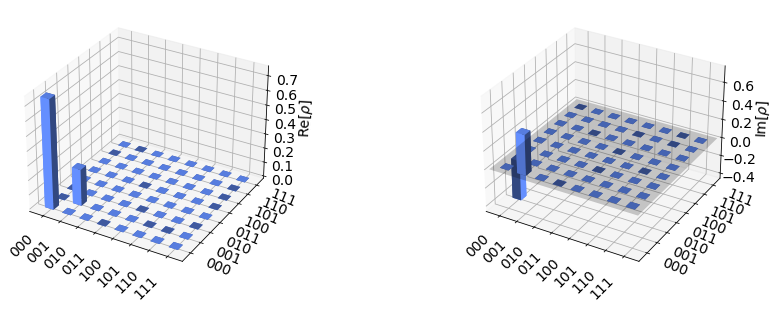

In [2]:
qc = QuantumCircuit(3, 3)
qc.rx(np.pi/3,0)
backend = Aer.get_backend('statevector_simulator')
statevector = execute(qc, backend).result().get_statevector()
display(statevector)
plot_state_city(statevector)

## Creating Quantum Teleportation Circuit

We add the next stage of our quantum circuit which entangles qubit 1 and qubit 2.

By applying the hadamard and CNOT gates we obtain the maximally entangled Bell state $|\Phi^+\rangle$ = $\frac{|00\rangle+|11\rangle}{\sqrt{2}}$.

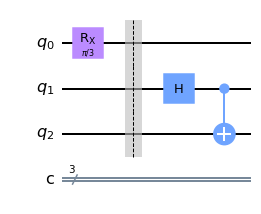

In [3]:
qc.barrier()
qc.h(1)
qc.cx(1,2)
qc.draw('mpl')

Next we add our teleportation protocol which is the most difficult step of this algorithm to get an intuition for. By applying CNOT and H gates between qubit 0 and qubit 1 we end up with a particular superposition state which when factored leaves terms which have qubit 0 and qubit 1 in the states $|00\rangle$,$|01\rangle$,$|10\rangle$,$|11\rangle$ and qubit 2 in 4 different $\alpha|x\rangle+\beta|y\rangle$ states. 

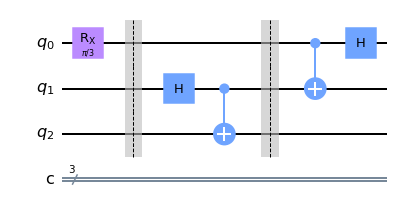

In [4]:
qc.barrier()
qc.cx(0,1)
qc.h(0)
qc.draw('mpl')

Measuring qubit 0 and qubit 1 we obtain one of the 4 states listed previously. We decide which operations to perform on qubit 2 depending on the results of these measurements. With the CNOT and CZ gates on qubit 2 we change it to some state $\alpha|0\rangle+\beta|1\rangle$ which we aimed to teleport.

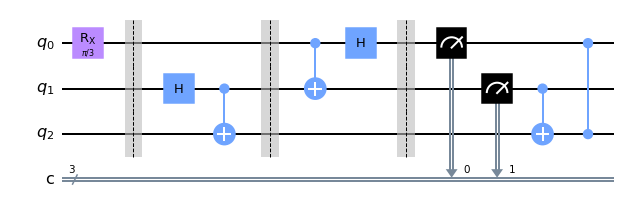

In [5]:
qc.barrier()
qc.measure(0,0)
qc.measure(1,1)
qc.cx(1,2)
qc.cz(0,2)
qc.draw('mpl')

Lastly. we check that our teleportation was performed successfully by rotating qubit 2 back to its original state $|0\rangle$ and measuring.

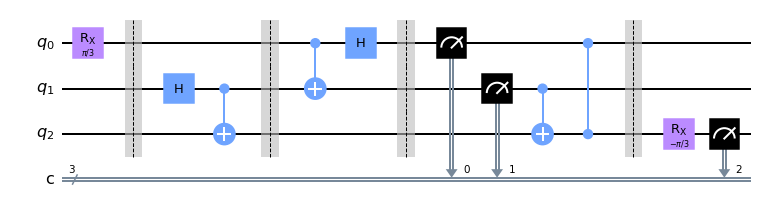

In [6]:
qc.barrier()
qc.rx(-np.pi/3,2)
qc.measure(2,2)
qc.draw('mpl')

## Running Quantum Teleportation Algorithm

Running this circuit now we obtain the following histogram. We see that we get results with all the possible combinations of qubit 0 and qubit 1 measurements and qubit 2 is measured as 0 meaning that the teleportation was successful. We also see that within statistical error each final results is obtained with a probability of 0.25 which is a result of the two hadamard gates contributing factors of $\frac{1}{\sqrt{2}}$.

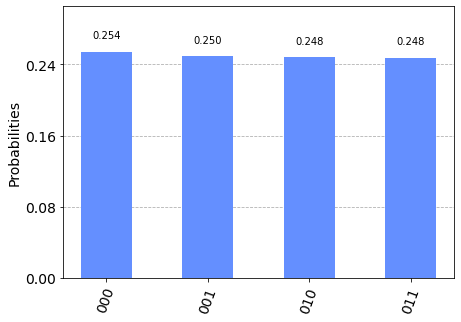

In [8]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=8192).result().get_counts()
plot_histogram(job)

## Adjusting Circuit to Run on Hardware

We once again create the same quantum state as before so we have a direct comparison to the noiseless case.

Statevector([0.8660254+0.j , 0.       -0.5j, 0.       +0.j ,
             0.       +0.j , 0.       +0.j , 0.       +0.j ,
             0.       +0.j , 0.       +0.j ],
            dims=(2, 2, 2))


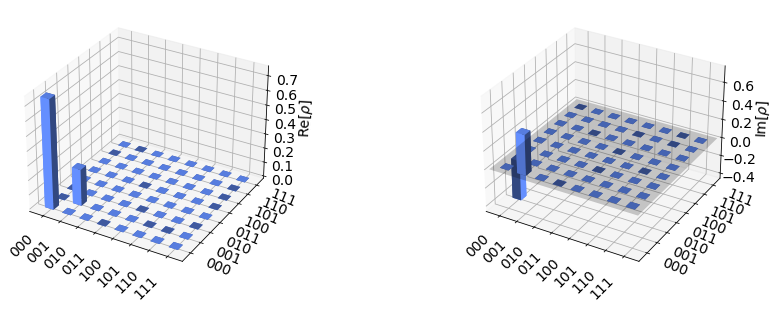

In [9]:
qc1 = QuantumCircuit(3, 3)
qc1.rx(np.pi/3,0)
backend = Aer.get_backend('statevector_simulator')
statevector = execute(qc1, backend).result().get_statevector()
display(statevector)
plot_state_city(statevector)

To run a circuit on real hardware all measurements have to be performed at the end of the circuit. To do this we use the deferred measurement principle which switches measurement gates with the corresponding conditional gates which come after them.

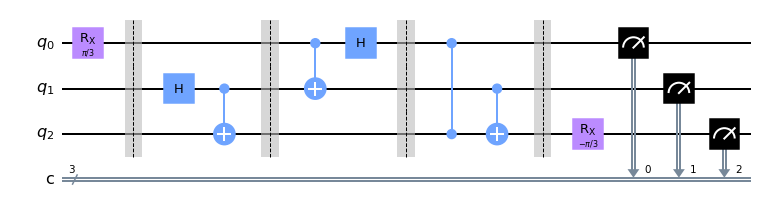

In [10]:
qc1.barrier()
qc1.h(1)
qc1.cx(1,2)
qc1.barrier()
qc1.cx(0,1)
qc1.h(0)
qc1.barrier()
qc1.cz(0,2)
qc1.cx(1,2)
qc1.barrier()
qc1.rx(-np.pi/3,2)
qc1.measure(0,0)
qc1.measure(1,1)
qc1.measure(2,2)
qc1.draw('mpl')

Running our new circuit on the noiseless simulator we see that the results are very similar to before. This means our new circuit works in the same way as the previous one.

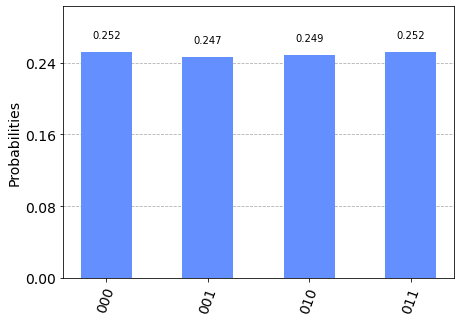

In [11]:
backend1 = Aer.get_backend('qasm_simulator')
job_sim = execute(qc1, backend1, shots=8192).result().get_counts()
plot_histogram(job_sim)

## Running on a Real Quantum Device

We load our IBM Quantum account onto the notebook and check the available providers and devices.

In [23]:
from qiskit import IBMQ
provider = IBMQ.enable_account('API Token')
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-4', project='reczA7aZpklv6xtnQ')>]

Running this command we can check all of the available devices. 

In [24]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

Next after selecting a particular device we get its coupling map and backend properties.

In [25]:
import qiskit.tools.jupyter

HW = 'ibmq_bogota'

device = IBMQ.get_provider(hub='ibm-q', group='open', project='main').get_backend(HW)
coupling_map = device.configuration().coupling_map
backend_properties = device.properties()

Using the coupling map and backend properties we can use the calibration of the selected device to create a noise model. A noise model allows us to simulate noisy results without having to run the circuit on the actual hardware.

C:\Users\cryan\anaconda3\envs\qiskit-stable\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (183226.38431319274 > 2 * 80663.98161302123). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\cryan\anaconda3\envs\qiskit-stable\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (183226.38431319274 > 2 * 80663.98161302123). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\cryan\anaconda3\envs\qiskit-stable\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (183226.38431319

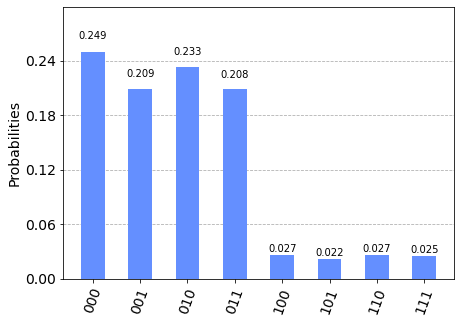

In [26]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import noise

# Creation of noise model and basis gate from backend properties

noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

bk = Aer.get_backend('qasm_simulator')
counts_noisy = execute(qc, shots=8192, backend=bk, coupling_map=coupling_map, 
                       basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts_noisy)

When running on the real device always select the same one as your noise model for the best comparison. Looking at both sets of noisy results we see that we end up measuring state where qubit 2 is measured to be 1 instead of 0 which either means the teleportation was performed incorrectly or there was an error when measuring qubit 2. The results on the actual hardware are still worse than the noise model results.

In [ ]:
from qiskit.tools.monitor import job_monitor
bk_real = provider.get_backend(HW)
job_noisy_real = execute(qc, shots=8192, backend=bk_real)
job_monitor(job_noisy_real)

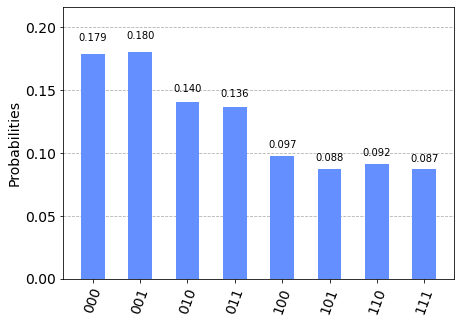

In [28]:
results_noisy_real = job_noisy_real.result()
counts_noisy_real = results_noisy_real.get_counts()
plot_histogram(counts_noisy_real)

## Quantum State Tomography

Quantum state tomography is a process which is useful to reconstruct the final quantum state $|\psi\rangle$ by measuring in different bases. It is particularly useful on quantum hardware when statevector simulations cannot be performed.

It works by having some final quantum state state $|\psi\rangle$ = $\alpha|0\rangle$ + $\beta|1\rangle$ and using this process to solve for $\alpha$ and $\beta$.

$\alpha|0\rangle$ + $\beta|1\rangle$ is in the $Z$-basis. It can also be written in the $X(|+\rangle,|-\rangle)$ and $Y(|+i\rangle,|-i\rangle)$ bases.

In this $X$-basis, we write the same quantum state as $\alpha|+\rangle$ + $\beta|-\rangle$ by applying a hadamard gate to our original state. Rearranging our $X$-basis state in the $Z$-basis which is because the measurements will be in terms of 0s and 1s, we get $\frac{\alpha+\beta}{\sqrt{2}}|0\rangle$ + $\frac{\alpha-\beta}{\sqrt{2}}|1\rangle$.

By the same logic, and applying a $R_X(\frac{\pi}{2})$-gate instead of a $H$-gate to change the original quantum state into the $Y$-basis, we get $\frac{\alpha+i\beta}{\sqrt{2}}|0\rangle$ + $\frac{\alpha-i\beta}{\sqrt{2}}|1\rangle$.

Looking at our amplitudes which give the probabilites to measure $|0\rangle$ and $|1\rangle$ from the different bases we see that we can compute $\alpha$ and $\beta$ through this process.

This process is carried out in the following circuits. The state $\alpha|0\rangle$ + $\beta|1\rangle$ is teleported to qubit 2 and instead of rotating the state back to $|0\rangle$ we apply the appropriate gate to change it to each of the different bases and then measure.

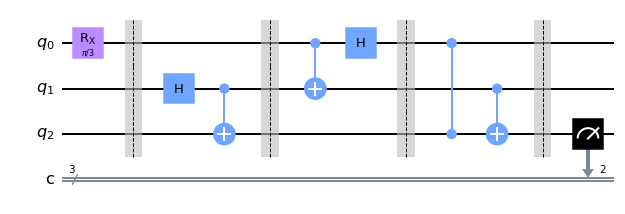

In [7]:
qc2 = QuantumCircuit(3, 3)
qc2.rx(np.pi/3,0)
qc2.barrier()
qc2.h(1)
qc2.cx(1,2)
qc2.barrier()
qc2.cx(0,1)
qc2.h(0)
qc2.barrier()
qc2.cz(0,2)
qc2.cx(1,2)
qc2.barrier()
qc2.measure(2,2)
qc2.draw('mpl')

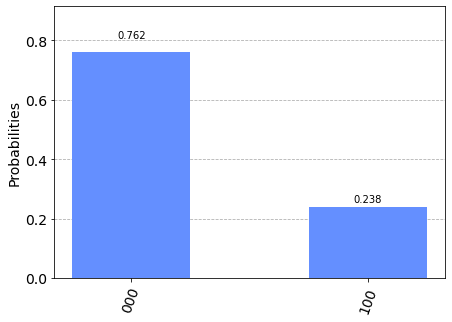

In [8]:
backend2 = Aer.get_backend('qasm_simulator')
job_sim = execute(qc2, backend2, shots=1024).result().get_counts()
plot_histogram(job_sim)

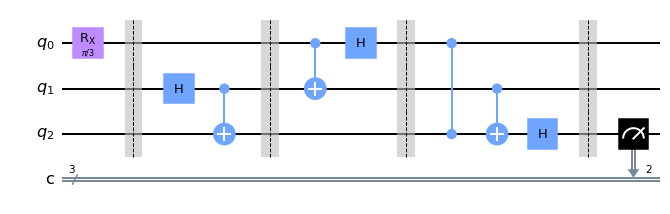

In [10]:
qc3 = QuantumCircuit(3, 3)
qc3.rx(np.pi/3,0)
qc3.barrier()
qc3.h(1)
qc3.cx(1,2)
qc3.barrier()
qc3.cx(0,1)
qc3.h(0)
qc3.barrier()
qc3.cz(0,2)
qc3.cx(1,2)
qc3.h(2)
qc3.barrier()
qc3.measure(2,2)
qc3.draw('mpl')

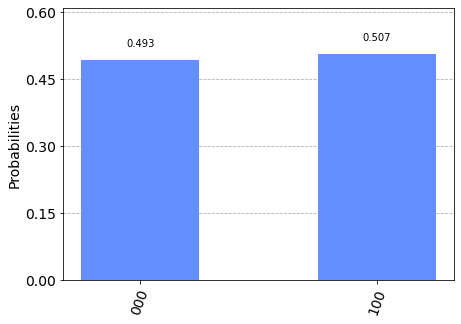

In [11]:
backend3 = Aer.get_backend('qasm_simulator')
job_sim = execute(qc3, backend3, shots=1024).result().get_counts()
plot_histogram(job_sim)

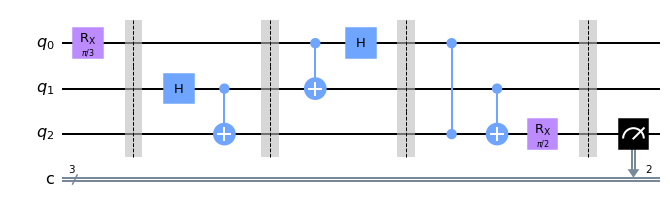

In [16]:
qc4 = QuantumCircuit(3, 3)
qc4.rx(np.pi/3,0)
qc4.barrier()
qc4.h(1)
qc4.cx(1,2)
qc4.barrier()
qc4.cx(0,1)
qc4.h(0)
qc4.barrier()
qc4.cz(0,2)
qc4.cx(1,2)
qc4.rx(np.pi/2,2)
qc4.barrier()
qc4.measure(2,2)
qc4.draw('mpl')

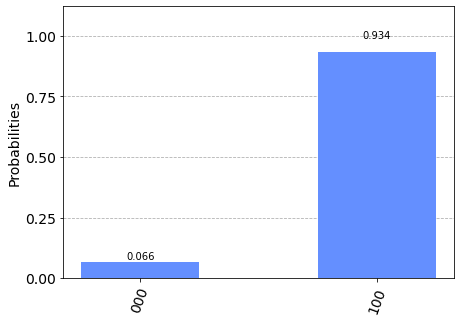

In [15]:
backend4 = Aer.get_backend('qasm_simulator')
job_sim = execute(qc4, backend4, shots=1024).result().get_counts()
plot_histogram(job_sim)